In [1285]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint

In [1286]:
# Parameters 
L = 10 # length of domain 
dx = 0.4 # mesh steps 
nx = int(L / dx) # mesh points
k0s = np.linspace(1, 4, nx) # momentum of wave pakcket [au] (0.01 to 5) with nx points
# T = L / (2 * k0s) # total time 
dt = 2 * dx**2 # time step 
# nt = (T / dt) # time points 

x = np.linspace(0, L, nx)
print(len(k0s))


25


In [1287]:
# Gaussian wave packet
def get_psi0(k0): 
    x0 = L / 4  # center of the wave packet
    sigma = L / 20  # width of the wave packet
    N = (np.pi * sigma ** 2)**(-1/4) # Normalization 
    gaussian = np.exp(-0.5 * ((x - x0) / sigma) ** 2)
    phase = np.exp(1j * k0 * x) 
    psi0 = (gaussian * phase) * N # initial wave function
    # norm = np.sum(psi0 * np.conj(psi0)) * dx # check in psi0 is normalized
    # print(norm)
    return psi0 

In [1288]:
# Potential initial conditions 
def get_pot(V0, a): 
    # V0 = 1 # potential strength
    # a = 0.05 # potential width percentage 
    V = np.zeros(nx)
    V[int((nx - a * nx) / 2):int((nx + a * nx) / 2)] = V0 # indices for start and end of the well 
    return V


In [1289]:
# Build coefficient matrix, a+
aplus = np.zeros((nx, nx),complex)
nu = 1j * dt / (4 * dx**2) # kinetic energy operator must be less than one to be stable

for i in range(len(aplus) - 1): # off diagonal 
    aplus[i,i+1] = aplus[i+1,i] = -nu 

for i in range(len(aplus)): # diagonal
    aplus[i,i] = 1 + 2 * nu 

aplus_inv = np.linalg.inv(aplus)


In [1290]:
# Build coefficient matrix, a-
aminus = np.zeros((nx, nx),complex)

for i in range(len(aminus)-1): # off diagonal 
    aminus[i,i+1] = aminus[i+1,i] = nu  

for i in range(len(aminus)): # diagonal
    aminus[i,i] = 1 - 2 * nu 

In [1291]:
# Crank-Nicholson
def get_psi(V):

    for k0 in k0s:
        # if k0 < 3:
        #     current_T = L / (k0)
        # else: 
        current_T = L / k0 

        current_nt = int(current_T / dt) 
        psi0 = get_psi0(k0)

        for t in range(current_nt): 
            f = np.exp(-1j * dt * V) * psi0
            psi = np.dot(aplus_inv, np.dot(aminus, f))
            psi0 = psi
        # print(k0 * dt / dx)

# #  # # # plotting 
#             if 3.11>k0 >3.1 and t % 10 == 0:
#                 plt.figure(figsize=(10, 300))
#                 num_cols = 2  # Number of columns for subplots
#                 num_rows = (current_nt + num_cols - 1) // num_cols

#                 plt.subplot(num_rows, num_cols, t + 1)
#                 plt.plot(x, np.abs(psi)**2)
#                 plt.plot(x, V)
#                 plt.title(f'Time step: {t}, velocity: {k0}')
#                 plt.xlabel('Position')
#                 plt.ylabel('Wave function')
#                 plt.tight_layout()
#         plt.show()

        yield psi # will yield the final psi at each k0 each time the loop has completed 

In [1299]:
def getRandT(final_psis, V0, a):
    center = int(nx/2) # center of well
    rcoefs = []
    tcoefs = []

    for psi in final_psis: 
        reflected_wavefunction = psi[0: center]
        transmitted_wavefunction = psi[center: nx] 
        refl = np.sum(reflected_wavefunction * np.conj(reflected_wavefunction)) * dx
        trans = np.sum(transmitted_wavefunction * np.conj(transmitted_wavefunction)) * dx
        rcoefs.append(np.real(refl))
        tcoefs.append(np.real(trans))
        # print(np.sum(psi * np.conj(psi)) * dx )# check in psi0 is normalized


    # print(f"Reflection coefficient (R): {rcoefs}")
    # print(f"Transmission coefficient (T): {tcoefs}")
    

    # es = k0s**2 / np.array(V0) # unitless energy

    # plt.plot(es, rcoefs, label = 'R')
    # plt.plot(es, tcoefs, label = 'T')
    # plt.xlabel("energy (k0^2 / V0)")
    # plt.ylabel('Refl & trans coefs')
    # plt.title(f'V0 = {V0}, a = {a}')
    # plt.legend()
    # plt.show()

    return rcoefs, tcoefs

# V0 = 1 # potential strength
# a = 0.05 # potential width percentage 
# V = get_pot(V0, a)
# final_psis = get_psi(V)
# rcoefs, tcoefs = getRandT(final_psis, V0, a)


In [1300]:
def gen_varyingpot():
    V0 = 1 # potential strength
    a = 0.05 # potential width percentage 
    
    while V0 <= 3:
        while a <= 0.2:
            V = get_pot(V0, a)
            final_psis = get_psi(V)
            rcoefs, tcoefs = getRandT(final_psis, V0, a)
            for (k0, rcoef, tcoef) in zip(k0s, rcoefs, tcoefs):
                yield(k0, V0, a, rcoef, tcoef)
            a += 0.05
            a = round(a, 2)
        a = 0.05 # reset a for next V0
        V0 += 1
          

In [1301]:
for varypoint in gen_varyingpot():
    print(varypoint)

(1.0, 1, 0.05, 0.6552085864876499, 0.30479270475545495)
(1.125, 1, 0.05, 0.5835837160231399, 0.3764175752199666)
(1.25, 1, 0.05, 0.45620891266830593, 0.5037923785748005)
(1.375, 1, 0.05, 0.425663295915454, 0.5343379953276527)
(1.5, 1, 0.05, 0.38439089145586774, 0.5756103997872393)
(1.625, 1, 0.05, 0.353114383736818, 0.6068869075062894)
(1.75, 1, 0.05, 0.32762149796673046, 0.6323797932763779)
(1.875, 1, 0.05, 0.30341288070053274, 0.6565884105425758)
(2.0, 1, 0.05, 0.280843387534504, 0.6791579037086045)
(2.125, 1, 0.05, 0.258750719444892, 0.7012505717982167)
(2.25, 1, 0.05, 0.2471456096102739, 0.7128556816328351)
(2.375, 1, 0.05, 0.22849031212996218, 0.731510979113147)
(2.5, 1, 0.05, 0.2240285344265316, 0.7359727568165779)
(2.625, 1, 0.05, 0.207990320844577, 0.7520109703985328)
(2.75, 1, 0.05, 0.1963601922510728, 0.7636410989920364)
(2.875, 1, 0.05, 0.2000702925957521, 0.759930998647358)
(3.0, 1, 0.05, 0.1945615963613729, 0.7654396948817372)
(3.125, 1, 0.05, 0.23701707203444544, 0.722984

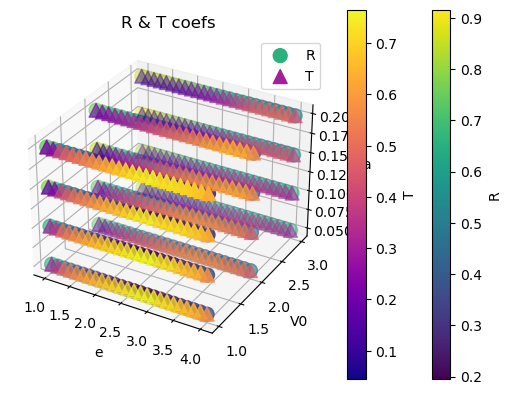

In [1304]:
k0_vals = []
V0_vals = []
a_vals = []
refl_coefs = []
trans_coefs = []

for varypoint in gen_varyingpot():
    k0_val, V0_val, a_val, refl_coef, trans_coef = varypoint
    k0_vals.append(k0_val)
    V0_vals.append(V0_val)
    a_vals.append(a_val)
    refl_coefs.append(refl_coef)
    trans_coefs.append(trans_coef)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# unitless_energy = k0_vals**2 / V0_vals

scatter_c1 = ax.scatter(k0_vals, V0_vals, a_vals, c=refl_coefs, cmap='viridis', s=100, marker='o', label='R')
scatter_c2 = ax.scatter(k0_vals, V0_vals, a_vals, c=trans_coefs, cmap='plasma', s=100, marker='^', label='T')

ax.set_xlabel('e')
ax.set_ylabel('V0')
ax.set_zlabel('a')
ax.set_title('R & T coefs')

cbar_c1 = fig.colorbar(scatter_c1, label='R')
cbar_c2 = fig.colorbar(scatter_c2, label='T')
ax.legend()

plt.show()